In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import mmcv
from mmtrack.apis import inference_mot, init_model as init_tracking_model
from torchreid.utils import FeatureExtractor as REIDFeatureExtractor
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info_new'
os.makedirs(id_viz_cache_root, exist_ok=True)

/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Get frame file data for all sessions

In [2]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [3]:
session_filter_list = [
 #    'classinsight-cmu_05681A_ghc_4301_201905011630',
 # 'classinsight-cmu_05681A_ghc_4301_201904171630',
 # 'classinsight-cmu_05681A_ghc_4301_201902201630',
 # 'classinsight-cmu_05681A_ghc_4301_201904101630',
 # 'classinsight-cmu_05681A_ghc_4301_201901231630',
                       
 # 'classinsight-cmu_05418A_ghc_4102_201902251200',
 # 'classinsight-cmu_05418A_ghc_4102_201904081200',
 # 'classinsight-cmu_05418A_ghc_4102_201905011200',
 # 'classinsight-cmu_05418A_ghc_4102_201904291200',
 # 'classinsight-cmu_05418A_ghc_4102_201904011200',
                       
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
                       
 # 'classinsight-cmu_21127J_ghc_4102_201904230930',
 # 'classinsight-cmu_21127J_ghc_4102_201903260930',
 # 'classinsight-cmu_21127J_ghc_4102_201904160930',
 # 'classinsight-cmu_21127J_ghc_4102_201904300930',
 # 'classinsight-cmu_21127J_ghc_4102_201903190930',
                       
 # 'classinsight-cmu_05410A_ghc_4301_201904151500',
 # 'classinsight-cmu_05410A_ghc_4301_201902251500',
 # 'classinsight-cmu_05410A_ghc_4301_201904081500',
 # 'classinsight-cmu_05410A_ghc_4301_201904221500',
 # 'classinsight-cmu_05410A_ghc_4301_201902181500',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
                       
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
                       
 'classinsight-cmu_05410B_ghc_4211_201902111500',
 'classinsight-cmu_05410B_ghc_4211_201903181500',
 'classinsight-cmu_05410B_ghc_4211_201904081500',
 'classinsight-cmu_05410B_ghc_4211_201904151500',
 'classinsight-cmu_05410B_ghc_4211_201904221500',
 'classinsight-cmu_05410B_ghc_4211_201901281500'
]

# Get data for sessionA

In [39]:
sample_course = '17214B'
sample_session_id = 'classinsight-cmu_17214B_ph_a21_201902271030-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face//17214B/classinsight-cmu_17214B_ph_a21_201902271030-front'

In [40]:
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sample_session_id}.csv")
# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
    else:
        eligible_id_map_dict[id2] = id1

sprint(eligible_id_map_dict)

# correct created eligible map for once more
for key in sorted(list(eligible_id_map_dict.keys())):
    key_value = eligible_id_map_dict[key]
    if key_value in eligible_id_map_dict.keys():
        eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
sprint(eligible_id_map_dict) 
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
sprint("replacing ids in old to new id maps")
for old_id in old_to_new_id_map:
    if old_to_new_id_map[old_id] in eligible_id_map_dict:
        print(f"replacing {old_id}:{old_to_new_id_map[old_id]} -->{eligible_id_map_dict[old_to_new_id_map[old_id]]}")
        old_to_new_id_map[old_id] = eligible_id_map_dict[old_to_new_id_map[old_id]]
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 


12 16
Dict: eligible_id_map_dict
Key: Value


{16: 12}

Dict: eligible_id_map_dict
Key: Value


{16: 12}

"replacing ids in old to new id maps" : replacing ids in old to new id maps
replacing 805:16 -->12
replacing 894:16 -->12
replacing 946:16 -->12


In [41]:
# map processed ids to tracking df
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[new_id_col].where(~df_tracking_new[new_id_col].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)




In [42]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,0,44958,44958
1,1,0,44958,44958
2,2,0,44958,44958
3,3,0,44958,44958
4,4,867,10836,9969
5,5,1647,44958,43311
6,6,4134,44958,40824
7,7,5601,44958,39357
8,8,5757,44958,39201
9,9,6003,44958,38955


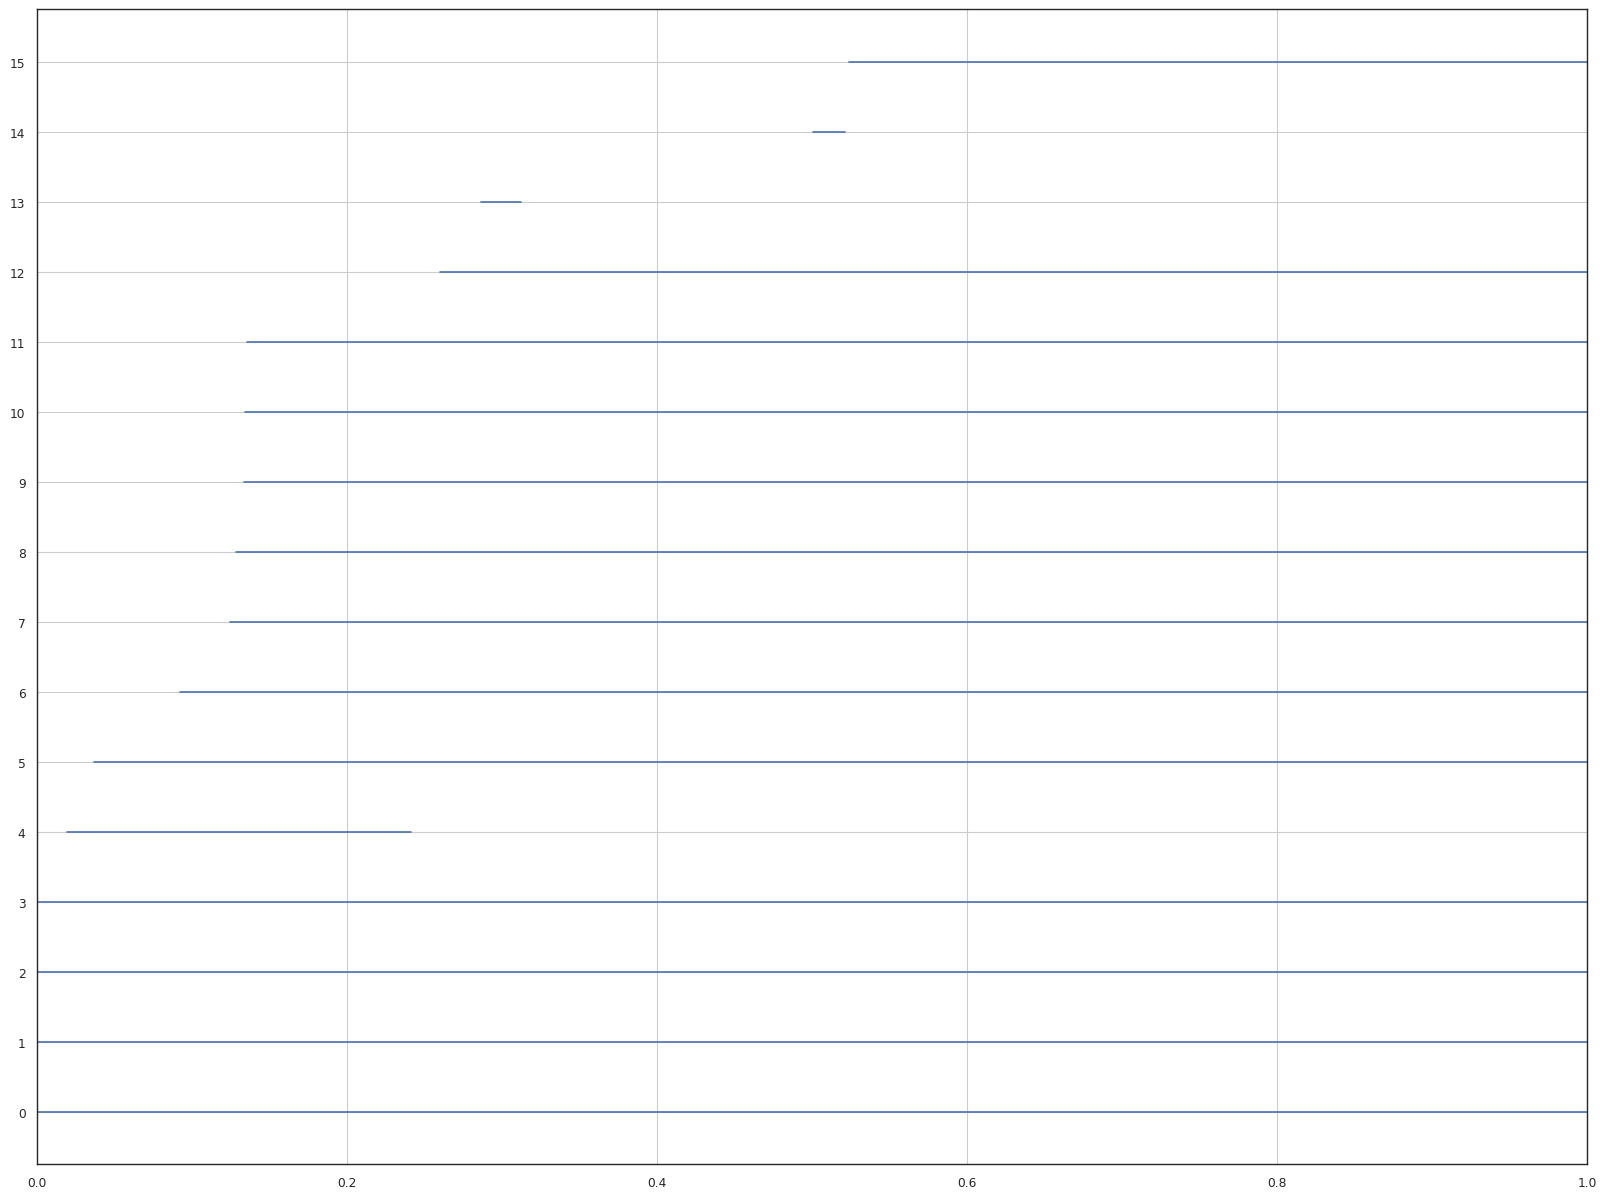

In [43]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [44]:
session_frames = df_tracking_new.index.values.tolist()
session_ids_covered = []
selected_frames = []
segments = []
segment_half_size = 50
for row_idx, row in df_id_start_stop.sort_values(by='total_idxs').iterrows():
    id_start, id_stop = row['min_idx'],row['max_idx']
    seg_mid = (id_start+id_stop)/2
    seg_start, seg_end = max(seg_mid-segment_half_size, 0), min(seg_mid+segment_half_size, total_idxs)
    is_id_covered = df_id_start_stop.apply(lambda row: (seg_end<=row['max_idx']) & (seg_start>=row['min_idx']),axis=1)
    seg_ids_covered = df_id_start_stop[is_id_covered]['id']
    new_ids_covered = [xr for xr in seg_ids_covered if xr not in session_ids_covered]
    if len(new_ids_covered)>0:        
        segment_frames = [xr for xr in session_frames if ((xr>=seg_start) and (xr<=seg_end))]
        selected_frames+=segment_frames
        segments.append((seg_start, seg_end, new_ids_covered, segment_frames))
        session_ids_covered+=new_ids_covered

sprint(segments)
    
    


List: segments


[
    (
        22912.0,
        23012.0,
        [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14],
        [
            22914,
            22917,
            22920,
            22923,
            22926,
            22929,
            22932,
            22935,
            22938,
            22941,
            22944,
            22947,
            22950,
            22953,
            22956,
            22959,
            22962,
            22965,
            22968,
            22971,
            22974,
            22977,
            22980,
            22983,
            22986,
            22989,
            22992,
            22995,
            22998,
            23001,
            23004,
            23007,
            23010
        ]
    ),
    (
        13402.0,
        13502.0,
        [13],
        [
            13404,
            13407,
            13410,
            13413,
            13416,
            13419,
            13422,
            13425,
            13428,
            13431,
            13434,
            13437,
            13440,
            13443,
            13446,
            13449,
            13452,
            13455,
            13458,
            13461,
            13464,
            13467,
            13470,
            13473,
            13476,
            13479,
            13482,
            13485,
            13488,
            13491,
            13494,
            13497,
            13500
        ]
    ),
    (
        5801.5,
        5901.5,
        [4],
        [
            5802,
            5805,
            5808,
            5811,
            5814,
            5817,
            5820,
            5823,
            5826,
            5829,
            5832,
            5835,
            5838,
            5841,
            5844,
            5847,
            5850,
            5853,
            5856,
            5859,
            5862,
            5865,
            5868,
            5871,
            5874,
            5877,
            5880,
            5883,
            5886,
            5889,
            5892,
            5895,
            5898,
            5901
        ]
    ),
    (
        34208.5,
        34308.5,
        [15],
        [
            34209,
            34212,
            34215,
            34218,
            34221,
            34224,
            34227,
            34230,
            34233,
            34236,
            34239,
            34242,
            34245,
            34248,
            34251,
            34254,
            34257,
            34260,
            34263,
            34266,
            34269,
            34272,
            34275,
            34278,
            34281,
            34284,
            34287,
            34290,
            34293,
            34296,
            34299,
            34302,
            34305,
            34308
        ]
    )
]

In [45]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [46]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")

[h264 @ 0xa169ac0] error while decoding MB 81 125, bytestream -5
[h264 @ 0xa169ac0] error while decoding MB 185 125, bytestream -9
[h264 @ 0xa169ac0] error while decoding MB 2 97, bytestream -5
[h264 @ 0x7f0d10abf200] error while decoding MB 81 125, bytestream -5
[h264 @ 0x1e6aff740] error while decoding MB 185 125, bytestream -9
[h264 @ 0x1e6bbfbc0] error while decoding MB 2 97, bytestream -5
[h264 @ 0x7f0d10a78100] error while decoding MB 63 87, bytestream -13
[h264 @ 0x1e6bbfbc0] error while decoding MB 2 97, bytestream -5
[h264 @ 0x7f0d10abf200] error while decoding MB 81 125, bytestream -5
[h264 @ 0x1e6aff740] error while decoding MB 185 125, bytestream -9
[h264 @ 0x7f0d10a78100] error while decoding MB 63 87, bytestream -13


Looped 0 images


[h264 @ 0x7f0d10aa0980] left block unavailable for requested intra mode
[h264 @ 0x7f0d10aa0980] error while decoding MB 0 40, bytestream 176140
[h264 @ 0x1e6aff740] error while decoding MB 142 71, bytestream -7
[h264 @ 0x1e6a4d9c0] error while decoding MB 58 40, bytestream -14
[h264 @ 0x7f0d3893f5c0] error while decoding MB 50 65, bytestream -9
[h264 @ 0x1e6780240] error while decoding MB 56 103, bytestream -5
[h264 @ 0x1e6325640] left block unavailable for requested intra4x4 mode -1
[h264 @ 0x1e6325640] error while decoding MB 0 103, bytestream 181207


Looped 10000 images


[h264 @ 0x7f0d38b90740] error while decoding MB 123 50, bytestream -13
[h264 @ 0x1e6ad28c0] error while decoding MB 6 98, bytestream -10
[h264 @ 0x1e6ad28c0] error while decoding MB 177 51, bytestream -11
[h264 @ 0x1e6325640] error while decoding MB 6 62, bytestream -5
[h264 @ 0x1e6780240] left block unavailable for requested intra4x4 mode -1
[h264 @ 0x1e6780240] error while decoding MB 0 120, bytestream 128679


Looped 20000 images


[h264 @ 0x1e6aff740] error while decoding MB 90 105, bytestream -25
[h264 @ 0x1e6325640] error while decoding MB 145 62, bytestream -5
[h264 @ 0x1e6bbfbc0] error while decoding MB 95 70, bytestream -5


Looped 30000 images


[h264 @ 0x1e6325640] error while decoding MB 76 53, bytestream -11
[h264 @ 0x7f0d3893f5c0] error while decoding MB 116 46, bytestream -5
[h264 @ 0x1e6a4d9c0] error while decoding MB 187 74, bytestream -5


Looped 40000 images


In [15]:
reid_extractor = REIDFeatureExtractor(model_name='osnet_x1_0',device='cuda')


Successfully loaded imagenet pretrained weights from "/home/prasoon/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352


In [47]:
frames_with_reids = {}
for seg_idx, (seg_start, seg_end, new_ids_covered, segment_frames) in enumerate(segments):
    frame_num=0
    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_num+=1
            frame_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_results)):
                old_id= int(frame_results[person_idx]['track_id'])
                frame_results[person_idx]['track_id'] =old_to_new_id_map[old_id]
            frame_img = deepcopy(frame_data_dict[frame_idx])

            if frame_results is not None:
                # face_results = deepcopy(frame_results)
                body_count = len(frame_results)
                body_frames = []
                body_indexes = []
                for body_index, tracking_info in enumerate(frame_results):
                    if type(tracking_info) == dict:
                        body_bbox = tracking_info['bbox']
                        X_TL, Y_TL, X_BR, Y_BR = body_bbox[:4].astype(int)
                        if ((Y_BR - Y_TL) < 5) | ((X_BR - X_TL) < 5):
                            print("Very small body space found, not running face detection...")
                            continue
                        if (X_TL<0) | (Y_TL<0) | (X_BR<0) | (Y_BR<0):
                            print(frame_idx, body_index, Y_TL,Y_BR, X_TL,X_BR, body_frame.shape)
                            print("Negative boundaries for bounding boxes, skipping...")
                            continue
    
                        body_frame = frame_img[Y_TL:Y_BR, X_TL:X_BR, :]
                        body_frames.append(body_frame)
                        body_indexes.append(body_index)
                        
                
                body_reid_features = reid_extractor(body_frames)
                for body_index, body_reid_embedding in zip(body_indexes, body_reid_features):
                    frame_results[body_index].update({
                        'reid_features': body_reid_embedding.detach().cpu().numpy()
                    })
                frames_with_reids[frame_idx] = deepcopy(frame_results)
                
    print(f"Done for segment {seg_idx}")
    # break
    
    

22962 12 705 1287 -1 354 (544, 610, 3)
Negative boundaries for bounding boxes, skipping...
22965 11 703 1303 -3 355 (542, 606, 3)
Negative boundaries for bounding boxes, skipping...
22968 12 703 1294 -4 352 (404, 342, 3)
Negative boundaries for bounding boxes, skipping...
22974 12 702 1282 -3 354 (538, 599, 3)
Negative boundaries for bounding boxes, skipping...
Done for segment 0
Done for segment 1
5802 0 889 1754 -12 565 (359, 833, 3)
Negative boundaries for bounding boxes, skipping...
Done for segment 2
Done for segment 3


In [32]:
frames_with_reids[44274][0]['reid_features'].shape

(512,)

In [49]:
session_results.keys(), sample_session_id

(dict_keys(['classinsight-cmu_17214B_ph_a21_201904241030-front']),
 'classinsight-cmu_17214B_ph_a21_201902271030-front')

In [50]:
session_results[sample_session_id]  = deepcopy(frames_with_reids)

In [53]:
# extract information at track_id level
session_id_oriented_results = {}
for session_id in session_results:
    reid_info = {}
    for frame_number in session_results[session_id]:
        for person in session_results[session_id][frame_number]:
            trackId = person['track_id']
            if trackId not in reid_info:
                reid_info[trackId] = []
            # get  gaze info
            try:
                person_reid = person['reid_features']
                reid_info[trackId].append([frame_number]+list(person_reid))
            except:
                print("reid not found",frame_number, trackId)
                continue
    
    for id in reid_info:
        reid_info[id] =pd.DataFrame(reid_info[id], columns=['frame']+np.arange(512).tolist()).set_index('frame')
    session_id_oriented_results[session_id]= deepcopy(reid_info)

reid not found 20862 13
reid not found 20865 13
reid not found 20868 13
reid not found 20871 13
reid not found 20874 13
reid not found 20877 13
reid not found 20880 13
reid not found 20883 13
reid not found 20886 13
reid not found 20889 13
reid not found 20892 13
reid not found 20895 13
reid not found 20898 13
reid not found 20901 13
reid not found 20904 13
reid not found 20907 13
reid not found 20910 13
reid not found 20913 13
reid not found 20916 13
reid not found 20919 13
reid not found 20922 13
reid not found 20925 13
reid not found 20928 13
reid not found 20931 13
reid not found 20934 10000
reid not found 20937 10000
reid not found 20940 10000
reid not found 20943 13
reid not found 20946 13
reid not found 20949 13
reid not found 20952 13
reid not found 20955 13
reid not found 20958 13
reid not found 13635 10
reid not found 13638 10
reid not found 13641 10
reid not found 13644 10
reid not found 13647 10
reid not found 13650 10
reid not found 13653 10
reid not found 13656 10
reid no

In [56]:
session_id_oriented_results.keys()

dict_keys(['classinsight-cmu_17214B_ph_a21_201904241030-front', 'classinsight-cmu_17214B_ph_a21_201902271030-front'])

In [105]:
CLU_EPS = 15
CLU_MIN_PTS = 50
cluster_based_embA = {}
sessionA = 'classinsight-cmu_17214B_ph_a21_201904241030-front'
emb_info = session_id_oriented_results[sessionA]
for sid in session_id_oriented_results[sessionA]:
    emb_clu = DBSCAN(min_samples=CLU_MIN_PTS, eps=CLU_EPS)
    try:
        if emb_info[sid].shape[0]>25000:
            emb_clu.fit(emb_info[sid].sample(25000).values)    
        else:
            emb_clu.fit(emb_info[sid].values)
    except:
        emb_clu=None
    if (emb_clu is None) or (max(emb_clu.labels_)<0):
        sprint(f"All frames are outliers, not proceeding with id {sid}")
        continue
    best_cluster_id = pd.Series(emb_clu.labels_[emb_clu.labels_>=0]).value_counts().index[0]
    frames = emb_info[sid].iloc[emb_clu.labels_==best_cluster_id].index.values
    cluster_based_embA[sid] = np.median(emb_info[sid].loc[frames],axis=0)
    sprint(f"Got cluster embedding for {sid}")


f"Got cluster embedding for {sid}" : Got cluster embedding for 11
f"Got cluster embedding for {sid}" : Got cluster embedding for 12
f"Got cluster embedding for {sid}" : Got cluster embedding for 9
f"Got cluster embedding for {sid}" : Got cluster embedding for 5
f"Got cluster embedding for {sid}" : Got cluster embedding for 4
f"Got cluster embedding for {sid}" : Got cluster embedding for 7
f"Got cluster embedding for {sid}" : Got cluster embedding for 1
f"Got cluster embedding for {sid}" : Got cluster embedding for 6
f"Got cluster embedding for {sid}" : Got cluster embedding for 20
f"All frames are outliers, not proceeding with id {sid}" : All frames are outliers, not proceeding with id 8
f"All frames are outliers, not proceeding with id {sid}" : All frames are outliers, not proceeding with id 21
f"All frames are outliers, not proceeding with id {sid}" : All frames are outliers, not proceeding with id 18
f"All frames are outliers, not proceeding with id {sid}" : All frames are outliers,

In [106]:
CLU_EPS = 15
CLU_MIN_PTS = 50
cluster_based_embB = {}
sessionB = 'classinsight-cmu_17214B_ph_a21_201902271030-front'
emb_info = session_id_oriented_results[sessionB]
for sid in session_id_oriented_results[sessionB]:
    emb_clu = DBSCAN(min_samples=CLU_MIN_PTS, eps=CLU_EPS)
    try:
        if emb_info[sid].shape[0]>25000:
            emb_clu.fit(emb_info[sid].sample(25000).values)    
        else:
            emb_clu.fit(emb_info[sid].values)
    except:
        emb_clu=None
    if (emb_clu is None) or (max(emb_clu.labels_)<0):
        sprint(f"All frames are outliers, not proceeding with id {sid}")
        continue
    best_cluster_id = pd.Series(emb_clu.labels_[emb_clu.labels_>=0]).value_counts().index[0]
    frames = emb_info[sid].iloc[emb_clu.labels_==best_cluster_id].index.values
    cluster_based_embB[sid] = np.median(emb_info[sid].loc[frames],axis=0)
    sprint(f"Got cluster embedding for {sid}")


f"All frames are outliers, not proceeding with id {sid}" : All frames are outliers, not proceeding with id 0
f"Got cluster embedding for {sid}" : Got cluster embedding for 6
f"Got cluster embedding for {sid}" : Got cluster embedding for 8
f"Got cluster embedding for {sid}" : Got cluster embedding for 1
f"Got cluster embedding for {sid}" : Got cluster embedding for 11
f"All frames are outliers, not proceeding with id {sid}" : All frames are outliers, not proceeding with id 7
f"Got cluster embedding for {sid}" : Got cluster embedding for 5
f"All frames are outliers, not proceeding with id {sid}" : All frames are outliers, not proceeding with id 10
f"Got cluster embedding for {sid}" : Got cluster embedding for 9
f"Got cluster embedding for {sid}" : Got cluster embedding for 3
f"All frames are outliers, not proceeding with id {sid}" : All frames are outliers, not proceeding with id 12
f"All frames are outliers, not proceeding with id {sid}" : All frames are outliers, not proceeding with id

In [107]:
session_cluster_emb={
    sessionA:deepcopy(cluster_based_embA),
    sessionB:deepcopy(cluster_based_embB),
}

In [108]:
# find matches

final_matches = []
for (sessionA, sessionB) in product(list(session_id_oriented_results.keys()), list(session_id_oriented_results.keys())):
    sessionA_key, sessionB_key = sessionA.split("_")[-1][4:8], sessionB.split("_")[-1][4:8]
    if not (sessionA==sessionB):
        # if sessionA not in session_matches:
        # match session A and session B based on gaze clustering
        match_scores_reid = {}
        for idA,idB in product(session_cluster_emb[sessionA].keys(), session_cluster_emb[sessionB].keys()):
            clu_embA, clu_embB = session_cluster_emb[sessionA][idA], session_cluster_emb[sessionB][idB]
            if (idA==10000) | (idB==10000):
                continue
            if idA not in match_scores_reid:
                match_scores_reid[idA] = {}
                
            if clu_embA is None or clu_embB is None:
                match_scores_reid[idA][idB] = np.inf
            else:
                match_distance = cdist(clu_embA.reshape(1,-1), clu_embB.reshape(1,-1))[0][0]
                match_scores_reid[idA][idB] = match_distance
        
        df_match_clu = pd.DataFrame(match_scores_reid) 
        for col in df_match_clu.columns:
            if col not in df_match_clu.columns:
                df_match_clu[col] = np.inf
            sessionB_matches = deepcopy(df_match_clu[col]).sort_values().head(3).index.values.tolist()
            for match_id in sessionB_matches:
                final_matches.append((sessionA_key, sessionB_key, f'{sessionA_key}_{col}', f'{sessionB_key}_{match_id}', match_scores_reid[col][match_id]))

df_final_matches = pd.DataFrame(final_matches, columns=['sessionA','sessionB','idA','idB','match_score_reid'])

In [109]:
df_final_matches.head(30)

,sessionA,sessionB,idA,idB,match_score_reid
0,0424,0227,0424_11,0227_8,17.257211
1,0424,0227,0424_11,0227_1,19.372535
2,0424,0227,0424_11,0227_11,20.597395
3,0424,0227,0424_12,0227_5,18.889822
4,0424,0227,0424_12,0227_6,19.267334
5,0424,0227,0424_12,0227_3,20.517570
6,0424,0227,0424_9,0227_11,21.308072
7,0424,0227,0424_9,0227_8,22.075853
8,0424,0227,0424_9,0227_1,22.881021
9,0424,0227,0424_5,0227_6,15.016569


In [104]:
df_final_matches.head(30)

,sessionA,sessionB,idA,idB,match_score_reid
0,0424,0227,0424_11,0227_8,18.234535
1,0424,0227,0424_11,0227_1,18.759459
2,0424,0227,0424_11,0227_11,20.795958
3,0424,0227,0424_12,0227_5,18.872933
4,0424,0227,0424_12,0227_6,19.267334
5,0424,0227,0424_12,0227_7,19.656516
6,0424,0227,0424_9,0227_11,21.308072
7,0424,0227,0424_9,0227_1,21.430620
8,0424,0227,0424_9,0227_8,22.075853
9,0424,0227,0424_5,0227_6,14.820952


In [66]:
distance_matrix = cdist(emb_info[11].values,emb_info[11].values)

In [67]:
distance_matrix.shape

(203, 203)

<Axes: >

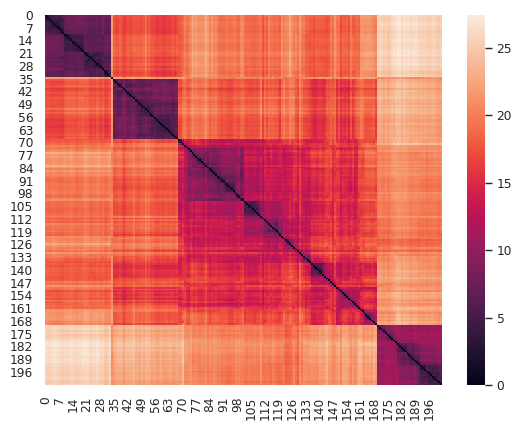

In [69]:
sns.heatmap(distance_matrix)